In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import numpy as np
#from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
import scipy.misc
import matplotlib
#import xgboost as XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten, Dropout, MaxPooling2D,MaxPooling3D, TimeDistributed, Conv2D, LSTM, SimpleRNN, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler

import io
import matplotlib.pyplot as plt
import imageio
from sklearn.metrics import r2_score
# from IPython.display import Image, display
# from ipywidgets import widgets, Layout, HBox
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import UpSampling3D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow import keras
import tensorflow_addons as tfa

from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, LSTM
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
import tensorflow as tf


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to enco

In [2]:
def load_data():
    data = []
    path = rf"{os.getcwd()}\src\yearly_data"
    for file in os.listdir(path):
        df = pd.read_csv(f'{path}/{file}')
        df.drop(columns=[df.columns[0]], axis=1, inplace=True)
        df.fillna(0.0, inplace=True)
        data.append(df.to_numpy())
    return np.array(data)

data = load_data()


In [3]:
def reshape_data(data):
    data_shifted = data[2:]
    data = data[:-2]
    data = data.reshape((38, 277, 228, 1))
    return data, data_shifted

data, data_shifted = reshape_data(data)

In [4]:
def train_test_split():
    train_dataset = data[:32]
    train_labels = data_shifted[:32]
    test_dataset = data[-6:]
    test_labels = data_shifted[-6:]
    print("Training Dataset Shapes: " + str(train_dataset.shape) + ", " + str(train_labels.shape))
    print("Validation Dataset Shapes: " + str(test_dataset.shape) + ", " + str(test_labels.shape))
    return train_dataset, train_labels, test_dataset, test_labels

train_dataset, train_labels, test_dataset, test_labels = train_test_split()

Training Dataset Shapes: (32, 277, 228, 1), (32, 277, 228)
Validation Dataset Shapes: (6, 277, 228, 1), (6, 277, 228)


In [5]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[i+1:end_ix+1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), n_steps

In [6]:
x_train, y_train, n_steps = split_sequence(train_dataset, 4)
x_test, y_test, n_steps = split_sequence(test_dataset,4)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (28, 4, 277, 228, 1), (28, 4, 277, 228, 1)
Validation Dataset Shapes: (2, 4, 277, 228, 1), (2, 4, 277, 228, 1)


In [7]:
seq = keras.Sequential(
    [
        keras.Input(shape = (None, *x_train.shape[2:])),
        layers.ConvLSTM2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', return_sequences=True),
        layers.BatchNormalization(),
        layers.Conv3D(filters=1, kernel_size=(3,3,3), activation='relu', padding='same')
    ]
)

seq.compile(loss='mse', optimizer='adam')
seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 277, 228, 8  2624      
                             )                                   
                                                                 
 batch_normalization (BatchN  (None, None, 277, 228, 8  32       
 ormalization)               )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 277, 228, 1  13888     
                             6)                                  
                                                                 
 batch_normalization_1 (Batc  (None, None, 277, 228, 1  64       
 hNormalization)             6)                                  
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, 277, 228, 3  5

In [8]:
start_time = time.time()
seq.fit(
    x_train,
    y_train,
    batch_size=1,
    epochs=40,
    validation_split=0.1
)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/40
25/25 [==============================] - 103s 4s/step - loss: 2342.3064 - val_loss: 4173.3013
Epoch 2/40
25/25 [==============================] - 93s 4s/step - loss: 2146.0393 - val_loss: 4194.4067
Epoch 3/40
25/25 [==============================] - 96s 4s/step - loss: 1971.8934 - val_loss: 4176.1743
Epoch 4/40
25/25 [==============================] - 89s 4s/step - loss: 1821.5681 - val_loss: 4051.1201
Epoch 5/40
25/25 [==============================] - 89s 4s/step - loss: 1713.8242 - val_loss: 3770.6990
Epoch 6/40
25/25 [==============================] - 87s 4s/step - loss: 1629.3076 - val_loss: 3403.7781
Epoch 7/40
25/25 [==============================] - 93s 4s/step - loss: 1562.1373 - val_loss: 3036.1882
Epoch 8/40
25/25 [==============================] - 92s 4s/step - loss: 1505.1011 - val_loss: 2494.1326
Epoch 9/40
25/25 [==============================] - 90s 4s/step - loss: 1408.7833 - val_loss: 1783.6122
Epoch 10/40
25/25 [==============================] - 88s 4s/ste

In [9]:
pred = seq.predict(x_test)

1/1 [==============================] - 2s 2s/step


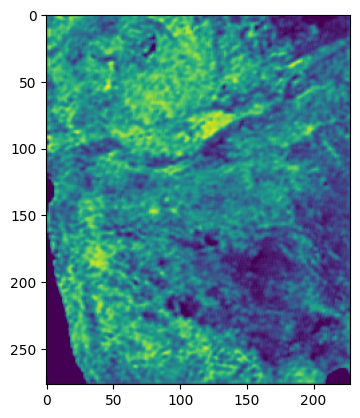

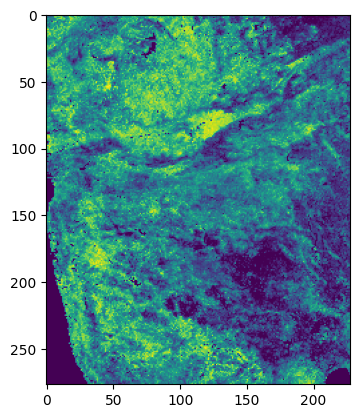

In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf

pred = pred[0][0].reshape(277,228)
yreal = y_test[0][0].reshape(277,228)
plt.imshow(pred)
plt.show()
plt.imshow(yreal)

In [13]:
import pickle

pickle.dump(seq, open(rf"{os.getcwd()}/models/conv2dlstm/conv2dlstm.pkl", "wb"))
np.save(rf"{os.getcwd()}/models/conv2dlstm/conv2dlstm.npy", seq.history)
seq.save(rf"{os.getcwd()}/models/conv2dlstm/conv2dlstm.h5")
model = load_model(rf"{os.getcwd()}/models/conv2dlstm/conv2dlstm.h5")
history_conv2 = np.load(rf"{os.getcwd()}/models/conv2dlstm/conv2dlstm.npy",allow_pickle=True).item()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\conv3d
......vars
.........0
.........1
...layers\conv_lstm2d
......vars
...layers\conv_lstm2d\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_1
......vars
...layers\conv_lstm2d_1\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_2
......vars
...layers\conv_lstm2d_2\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_3
......vars
...layers\conv_lstm2d_3\cell
......vars
.........0
.........1
.........2
...layers\conv_lstm2d_4

In [14]:
prediction = seq.predict(x_test)

1/1 [==============================] - 1s 1s/step


In [23]:
model = seq
from sklearn.metrics import r2_score

test_r2_scores = []
test_mae = []
test_mse = []
for i in range(len(prediction[0])):
    pred = prediction[0][i].reshape(277,228)
    y_real = test_labels[i].reshape(277,228)
    r2 = r2_score(y_real,pred)
    test_r2_scores.append(r2)
    error = (pred - y_real).reshape(277*228)
    mae = sum(abs(error))/len(error)
    test_mae.append(mae)
    mse = np.mean((error) ** 2)
    test_mse.append(mse)


print("Training Time : ConvLSTM2D : ", training_time)
print("R2 Score for ConvLSTM2D : ", sum(test_r2_scores)/len(test_r2_scores))
print("MSE for ConvLSTM2D : ", sum(test_mse)/len(test_mse))
print("MAE Score ConvLSTM2D : ", sum(test_mae)/len(test_mae))

Training Time : ConvLSTM2D :  3588.158034801483
R2 Score for ConvLSTM2D :  -0.5679159333218179
MSE for ConvLSTM2D :  688.2943317442558
MAE Score ConvLSTM2D :  21.364568101422503
